In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import pandas as pd
%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
# load data
est = pd.read_csv('../data/scheduling_estimates')
ideal = pd.read_csv('../data/scheduling_ideal')

In [7]:
# TODO: split figure in five rows (small, large compute cluster): wt-over-wt-over-scatter
# remove gaps

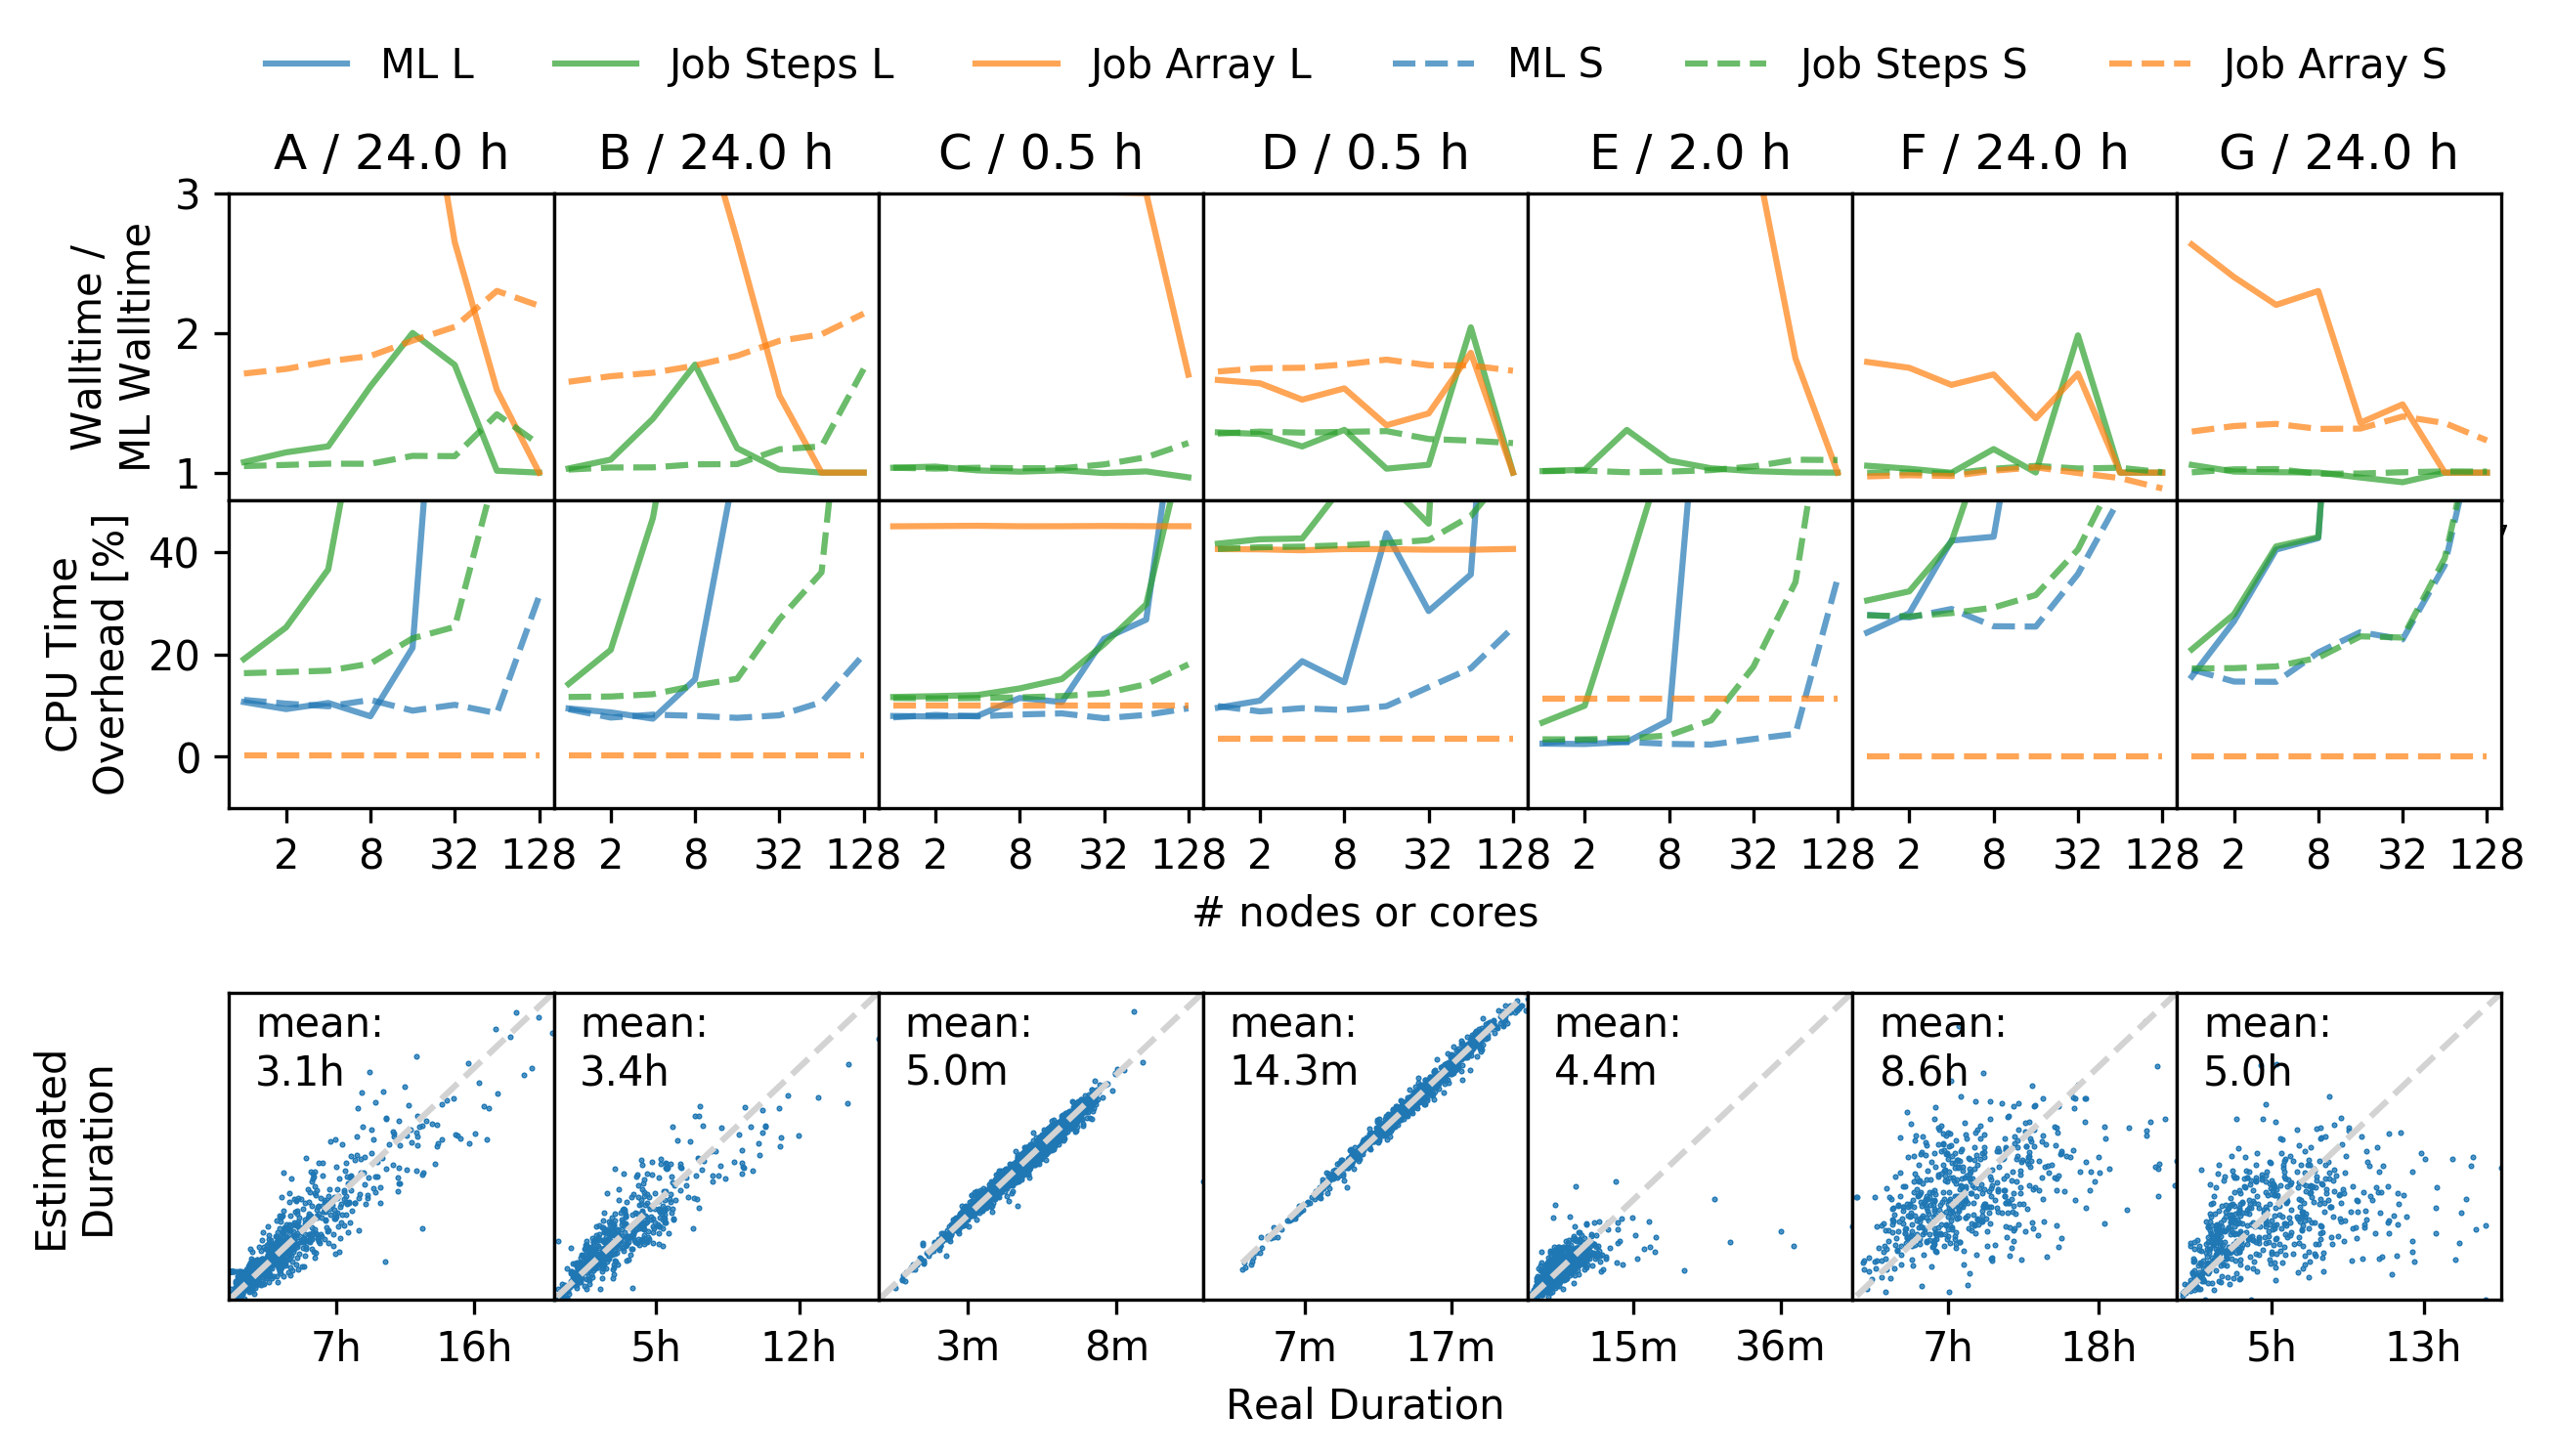

In [10]:
columns = sorted(est.dataset.unique())
usefiles = {'A': 'A_nfchl.txt', 'B': 'B_nfchl.txt', 'C': 'C_nfchl.txt', 'D': 'D_nfchl.txt', 'E': 'E_nfchl.txt', 'F': 'F_nfchl_cpu_to_wall.txt', 'G': 'G_nBoB_cpu_to_wall.txt',}

# Gridspec
fig = plt.figure(figsize=(10,5), dpi=300)

gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios=(2,1), hspace=0.4)
gsupper = gridspec.GridSpecFromSubplotSpec(2, 7, subplot_spec=gs0[0], hspace=0., wspace=0)
gslower = gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=gs0[1], wspace=0)

for col in range(7):
    ax = plt.Subplot(fig, gsupper[0, col])
    fig.add_subplot(ax)
for col in range(7):
    ax = plt.Subplot(fig, gsupper[1, col])
    fig.add_subplot(ax)
for col in range(7):
    ax = plt.Subplot(fig, gslower[0, col])
    fig.add_subplot(ax)

axs = [fig.axes[0:7], fig.axes[7:14], fig.axes[14:21]]

# Plot
linestyles = {'scicore': '--', 'cscs': '-'}
methods = {'ML/redis': '#1f77b4', 'jobarray': '#ff7f0e', 'greasy': '#2ca02c'}
times = {'A': 24, 'B': 24, 'C': 0.5, 'D': 0.5, 'E': 2, 'F': 24, 'G': 24 }
names = {'ML/redis': 'ML', 'jobarray': 'Job Array', 'greasy': 'Job Steps'}
labels = {'cscs': ' L', 'scicore': ' S'}

for idx, dataset in enumerate(sorted(est.dataset.unique())):
    time = times[dataset]
    s = est.query('dataset == @dataset & times == @time')
    i = ideal.query('dataset == @dataset').iloc[0]
    axs[0][idx].set_title('%s / %3.1f h' % (dataset, time))
    
    # Walltime
    for name, group in s.groupby('cluster method'.split()):
        cluster = name[0]
        baseline = s.query('cluster == @cluster & method=="ML/redis"').groupby('workers').min().reset_index()
        if name[1] == 'ML/redis':
            continue
        axs[0][idx].semilogx(group.workers, group.walltime.values / baseline.walltime.values, linestyle=linestyles[name[0]], color=methods[name[1]], label=names[name[1]] + labels[name[0]], alpha=0.7, basex=2)
    
    
    # Overhead
    for name, group in s.groupby('cluster method'.split()):
        axs[1][idx].semilogx(group.workers, (group.cputime / i.cputime)*100 - 100, linestyle=linestyles[name[0]], color=methods[name[1]], label=names[name[1]] + labels[name[0]], alpha=0.7, basex=2)
    
    # Scatter
    _ = np.loadtxt('../data/%s' % usefiles[dataset])
    real, predicted = _[:, 0], _[:, 1]
    predicted[predicted < 0] = np.median(predicted)
    scaling = np.max(real)
    axs[2][idx].scatter(real/scaling, predicted/scaling, s=0.2)
    axs[2][idx].plot((min(real/scaling), max(real/scaling)), (min(real/scaling), max(real/scaling)), color='lightgrey', linestyle='--', label='ideal')
    labelval = [close_even_time(_*scaling) for _ in [0.33, 0.8]]
    axs[2][idx].set_xticks(np.array(labelval)/scaling)
    axs[2][idx].set_xticklabels([human_label_time(_) for _ in labelval])
    axs[2][idx].set_xlim(0, 1)
    axs[2][idx].set_ylim(0, 1)
    axs[2][idx].text(s="mean:\n%s" % human_time(np.mean(real)), x=0.08, y=0.7, transform=axs[2][idx].transAxes)

axs[0][0].set_ylabel('Walltime /\nML Walltime')
for column in range(7):
    axs[0][column].set_ylim(0.8, 3)
    axs[0][column].set_xticks(4**np.arange(4)*2)
    if column > 0:
        axs[0][column].set_yticks([])
    
for column in range(7):
    axs[1][column].set_ylim(-10, 50)
    axs[1][column].set_xticks(4**np.arange(4)*2)
    if column > 0:
        axs[1][column].set_yticks([])
    axs[1][column].xaxis.set_major_formatter(ScalarFormatter())
axs[1][0].set_ylabel('CPU Time\nOverhead [%]')
axs[1][3].set_xlabel('# nodes or cores')

axs[2][0].set_ylabel('Estimated\nDuration\n\n')
for column in range(7):
    axs[2][column].set_yticks([])
axs[2][3].set_xlabel('Real Duration')

axs[1][0].legend(ncol=6, loc='upper left', frameon=False, bbox_to_anchor=(0., 2.6, 1.5, 0.0))

#plt.savefig('scheduling.pdf')

In [7]:
def human_time(seconds):
    minutes = seconds/60
    if minutes < 60:
        return '%3.1fm' % minutes
    hours = minutes / 60
    return '%3.1fh' % hours
human_time(29960)

'8.3h'

In [8]:
def close_even_time(seconds):
    minutes = seconds/60
    if minutes < 60:
        return int(minutes)*60
    hours = minutes/60
    return int(hours)*3600

In [10]:
close_even_time(3700)

3600

In [9]:
def human_label_time(seconds):
    minutes = seconds/60
    if minutes < 60:
        return '%dm' % minutes
    hours = minutes / 60
    return '%dh' % hours
human_label_time(29960)

'8h'

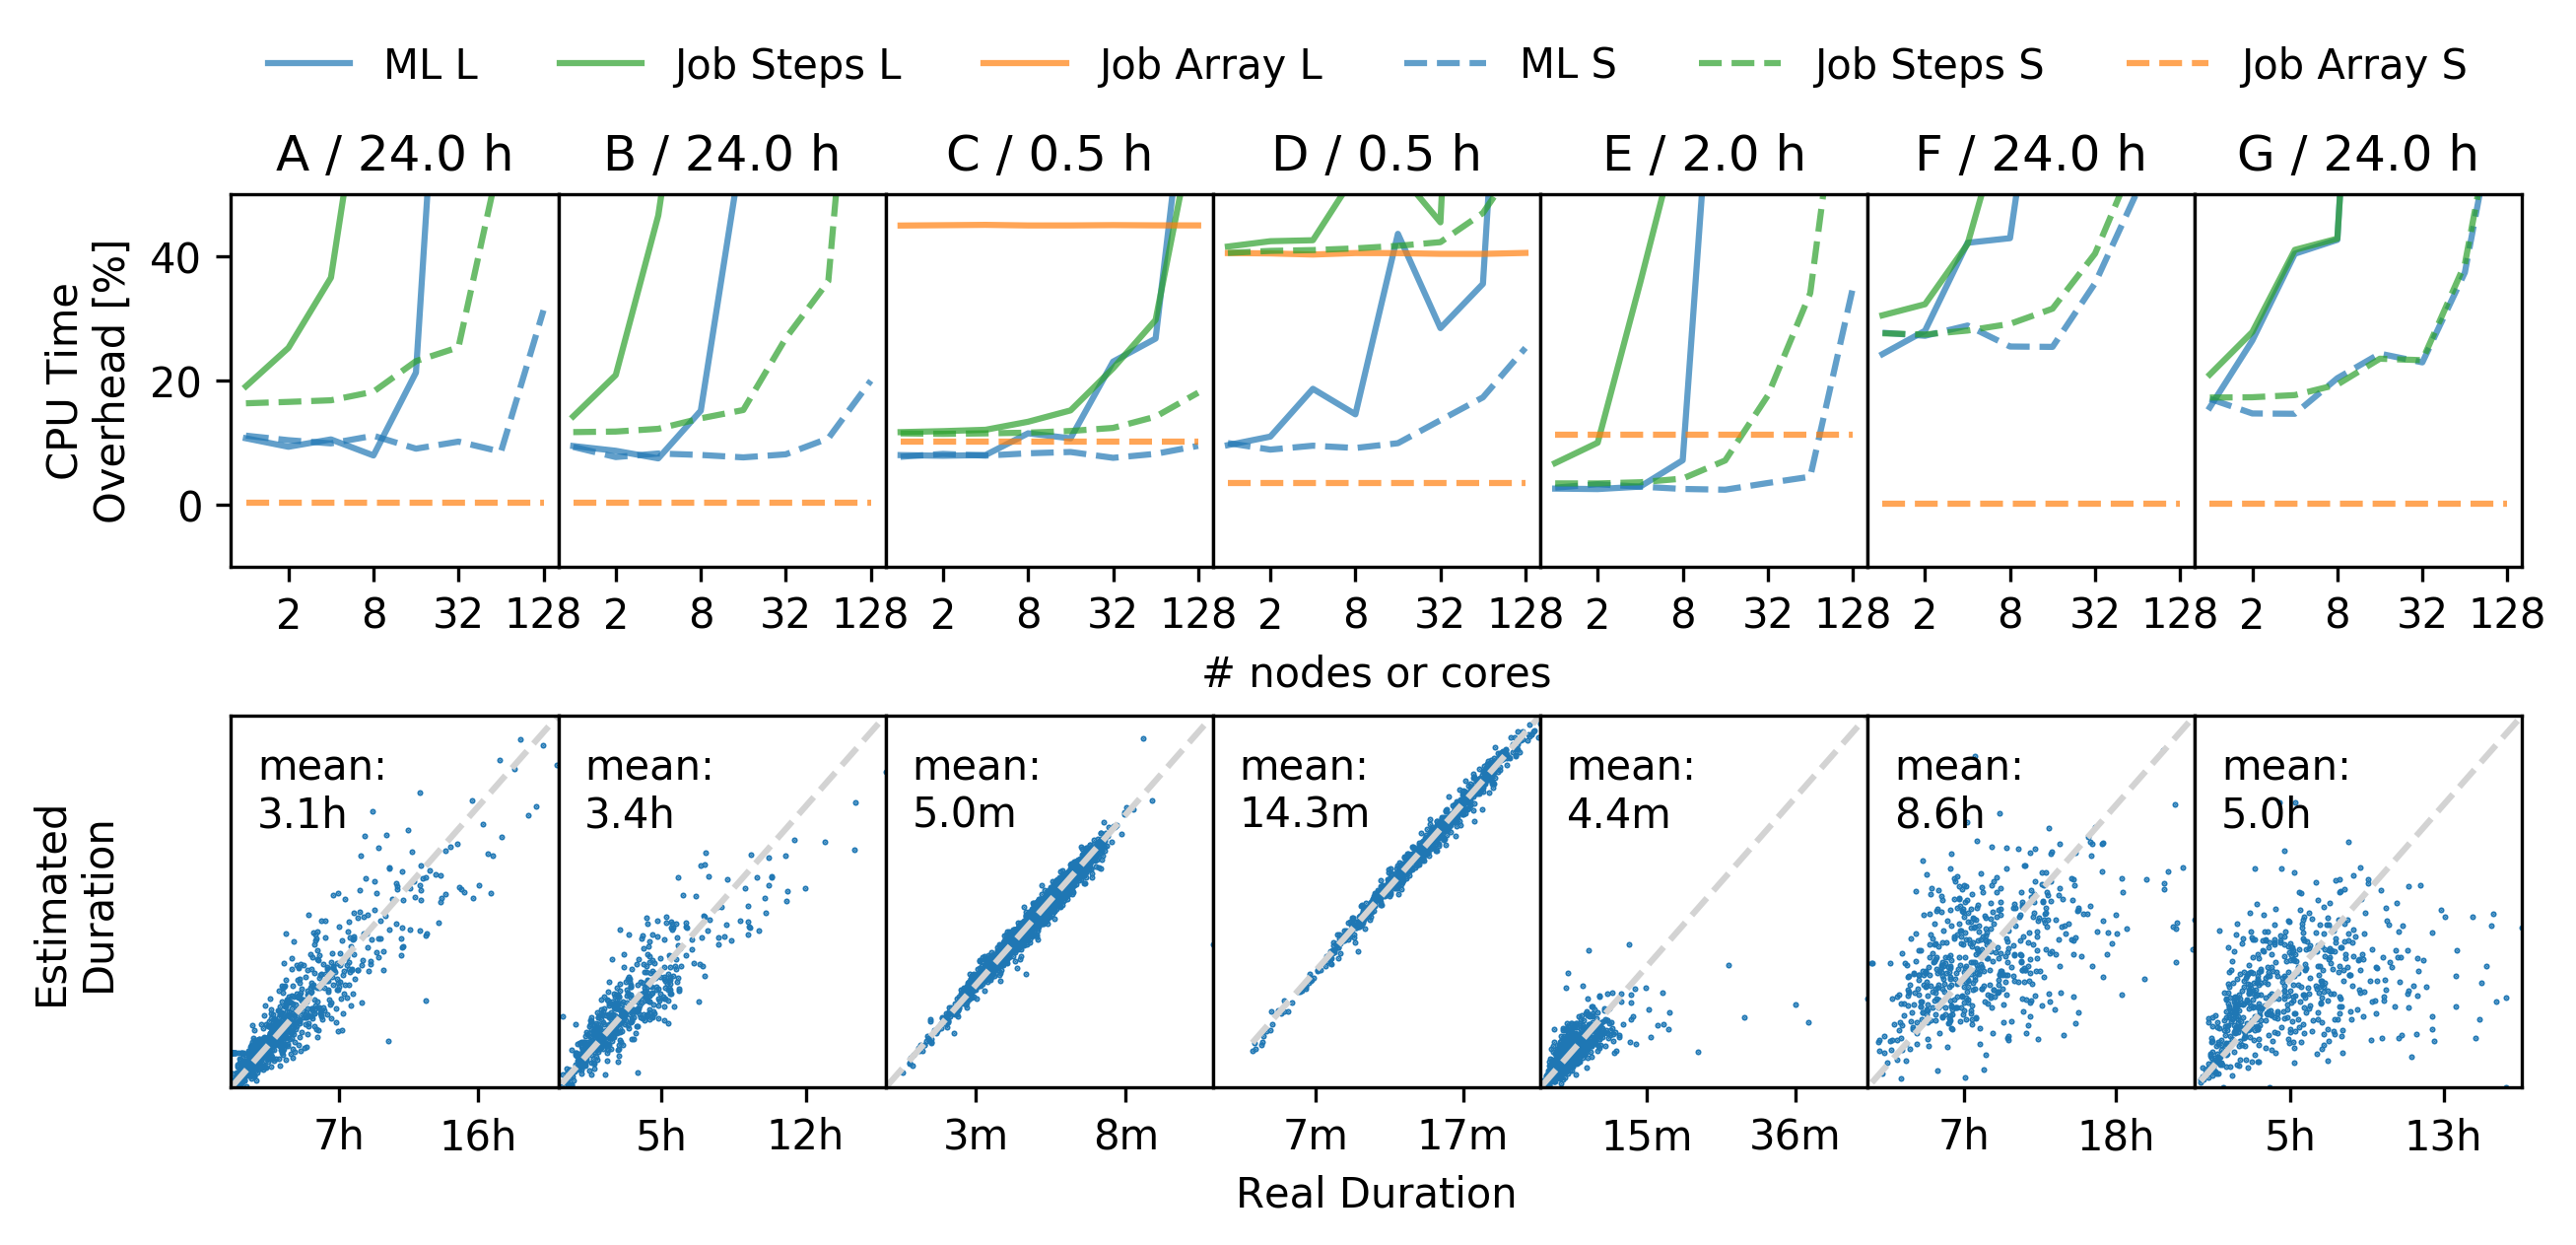

In [11]:
columns = sorted(est.dataset.unique())
usefiles = {'A': 'A_nfchl.txt', 'B': 'B_nfchl.txt', 'C': 'C_nfchl.txt', 'D': 'D_nfchl.txt', 'E': 'E_nfchl.txt', 'F': 'F_nfchl_cpu_to_wall.txt', 'G': 'G_nBoB_cpu_to_wall.txt',}

# Gridspec
fig = plt.figure(figsize=(10,4), dpi=300)

gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios=(1,1), hspace=0.4)
gsupper = gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=gs0[0], hspace=0., wspace=0)
gslower = gridspec.GridSpecFromSubplotSpec(1, 7, subplot_spec=gs0[1], wspace=0)

for col in range(7):
    ax = plt.Subplot(fig, gsupper[0, col])
    fig.add_subplot(ax)
for col in range(7):
    ax = plt.Subplot(fig, gslower[0, col])
    fig.add_subplot(ax)

axs = [fig.axes[0:7], fig.axes[7:14]]

# Plot
linestyles = {'scicore': '--', 'cscs': '-'}
methods = {'ML/redis': '#1f77b4', 'jobarray': '#ff7f0e', 'greasy': '#2ca02c'}
times = {'A': 24, 'B': 24, 'C': 0.5, 'D': 0.5, 'E': 2, 'F': 24, 'G': 24 }
names = {'ML/redis': 'ML', 'jobarray': 'Job Array', 'greasy': 'Job Steps'}
labels = {'cscs': ' L', 'scicore': ' S'}

for idx, dataset in enumerate(sorted(est.dataset.unique())):
    time = times[dataset]
    s = est.query('dataset == @dataset & times == @time')
    i = ideal.query('dataset == @dataset').iloc[0]
    axs[0][idx].set_title('%s / %3.1f h' % (dataset, time))
    
    # Overhead
    for name, group in s.groupby('cluster method'.split()):
        axs[0][idx].semilogx(group.workers, (group.cputime / i.cputime)*100 - 100, linestyle=linestyles[name[0]], color=methods[name[1]], label=names[name[1]] + labels[name[0]], alpha=0.7, basex=2)
    
    # Scatter
    _ = np.loadtxt('../data/%s' % usefiles[dataset])
    real, predicted = _[:, 0], _[:, 1]
    predicted[predicted < 0] = np.median(predicted)
    scaling = np.max(real)
    axs[1][idx].scatter(real/scaling, predicted/scaling, s=0.2)
    axs[1][idx].plot((min(real/scaling), max(real/scaling)), (min(real/scaling), max(real/scaling)), color='lightgrey', linestyle='--', label='ideal')
    labelval = [close_even_time(_*scaling) for _ in [0.33, 0.8]]
    axs[1][idx].set_xticks(np.array(labelval)/scaling)
    axs[1][idx].set_xticklabels([human_label_time(_) for _ in labelval])
    axs[1][idx].set_xlim(0, 1)
    axs[1][idx].set_ylim(0, 1)
    axs[1][idx].text(s="mean:\n%s" % human_time(np.mean(real)), x=0.08, y=0.7, transform=axs[1][idx].transAxes)

for column in range(7):
    axs[0][column].set_ylim(-10, 50)
    axs[0][column].set_xticks(4**np.arange(4)*2)
    if column > 0:
        axs[0][column].set_yticks([])
    axs[0][column].xaxis.set_major_formatter(ScalarFormatter())
axs[0][0].set_ylabel('CPU Time\nOverhead [%]')
axs[0][3].set_xlabel('# nodes or cores')

axs[1][0].set_ylabel('Estimated\nDuration\n\n')
for column in range(7):
    axs[1][column].set_yticks([])
axs[1][3].set_xlabel('Real Duration')

axs[0][0].legend(ncol=6, loc='upper left', frameon=False, bbox_to_anchor=(0., 1.5, 1.5, 0.0))
plt.savefig('scheduling_slim.pdf', bbox_inches='tight')